# Anomaly Detection in CNC Machines Using Autoencoders

Detecting failing, or worn tools, can be useful on today's high-throughput CNC machines. One way to do this is through anomaly detection. We will be using the milling data from the BEST lab at UC Berkeley.

Here is what a milling CNC machine may look like (from [NVT Technologies](https://flic.kr/p/3b14cE)):

![CNC machine](https://i.imgur.com/7TJGRfq.jpg)

Let's begin by looking at the data.

# 1. Data Exploration

In [1]:
import scipy.io as sio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
from pathlib import Path
import datetime

Milling data is in the repo, but can also be downloaded from the [NASA Prognostics Center](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#milling). Extract the mill.zip to the working directory.

In [2]:
data_folder = Path()  # mill.mat should be in the pwd
data_file = data_folder / 'mill.mat'

# load the data from the matlab file
m = sio.loadmat(data_file,struct_as_record=True)

# store the 'mill' data in a seperate np array
data = m['mill']

# store the field names in the data np array in a tuple, l
l = data.dtype.names

# create empty dataframe for the labels
df_labels = pd.DataFrame()

# get the labels from the original .mat file and put in dataframe
for i in range(7):
    # list for storing the label data for each field
    x = []
    
    # iterate through each of the unique cuts
    for j in range(167):
        x.append(data[0,j][i][0][0])
    x = np.array(x)
    df_labels[str(i)] = x

# add column names to the dataframe
df_labels.columns = l[0:7]
    
# create a column with the unique cut number
df_labels['cut_no'] = [i for i in range(167)]
df_labels.head()

,case,run,VB,time,DOC,feed,material,cut_no
0,1,1,0.00,2,1.5,0.5,1,0
1,1,2,NaN,4,1.5,0.5,1,1
2,1,3,NaN,6,1.5,0.5,1,2
3,1,4,0.11,7,1.5,0.5,1,3
4,1,5,NaN,11,1.5,0.5,1,4


There are 167 cuts in total. Each cut has six measurements being taken at a sampling rate of 250 Hz and 9000 sampling point. The six signals are:
- **smcAC**: AC spindle motor current
- **smcDC**: DC spindle motor current
- **vib_table**: Table vibration
- **vib_spindle**: Spindle vibration
- **AE_table**: Acoustic emission at table
- **AE_spindle**: Acoustic emission at spindle

In [3]:
# list of the six signals in each cut
l[7:]

('smcAC', 'smcDC', 'vib_table', 'vib_spindle', 'AE_table', 'AE_spindle')

There are 16 distinct cases, with a varying number of runs per case. The feed rate will be either 0.25 or 0.5 mm/rev for each case. See the Readme.pdf in the mill.zip file for more details.

Let's look at one of the cuts:

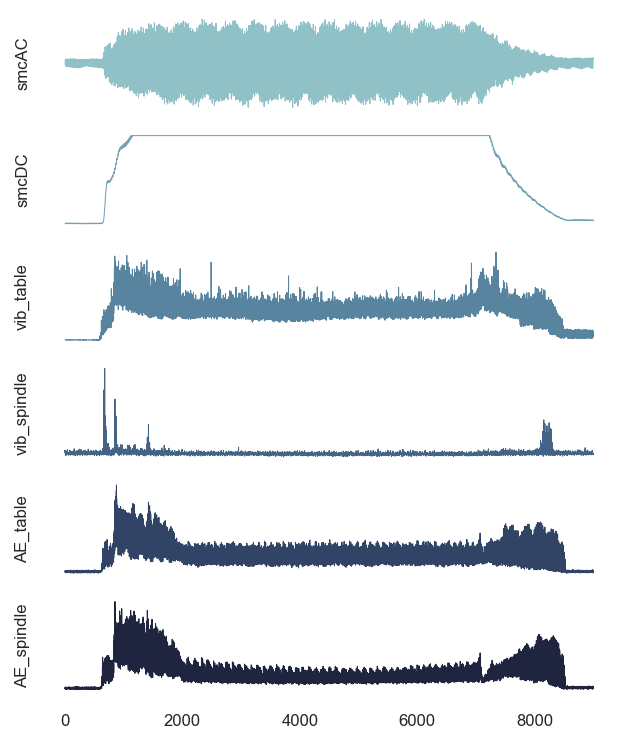

In [4]:
def plot_cut(cut_signal, signals_trend):
    
    # define colour palette and seaborn style
    pal = sns.cubehelix_palette(6, rot=-.25, light=.7)
    sns.set(style="white", context="notebook")
    
    fig, axes = plt.subplots(6, 1,dpi=150, figsize=(5,6), sharex=True, constrained_layout=False,)

    # go through each of the signals
    for i in range(6):
        axes[i].plot(cut_signal[signals_trend[i]],color=pal[i],linewidth=0.5, alpha=1)
        axis_label = signals_trend[i]
        axes[i].set_ylabel(axis_label,fontsize=8)
        if i != 5:
            axes[i].spines["top"].set_visible(False)
            axes[i].spines["right"].set_visible(False)
            axes[i].spines["left"].set_visible(False)
            axes[i].spines["bottom"].set_visible(False)
            axes[i].set_yticks([])
        else:
            axes[i].spines["top"].set_visible(False)
            axes[i].spines["right"].set_visible(False)
            axes[i].spines["left"].set_visible(False)
            axes[i].spines["bottom"].set_visible(False)
            axes[i].set_yticks([])
            axes[i].tick_params(axis="x", labelsize=8)
    
    plt.show()
    
signals_trend = l[7:] # there are 6 types of signals, smcAC to AE_spindle
cut_signal = data[0,166] 

plot_cut(cut_signal, signals_trend)

# 2. Data Prep

We will add the state of the tool (similar to what is done here: https://ieeexplore.ieee.org/abstract/document/8681165 ):

**Healthy Sate** (label=0): 0-0.2mm flank wear <br/>
**Degredation State** (label=1): 0.2-0.7mm flank wear <br/>
**Failure State** (label=2): >0.7mm flank wear <br/>

However, when we get to the anomaly detection, we will only train the model on the healthy and degredation states (we will label both these classes as "normal").

In [5]:
def tool_state(cols):
    '''Add the label to the cut. Categories are:
    Healthy Sate (label=0): 0~0.2mm flank wear
    Degredation State (label=1): 0.2~0.7mm flank wear
    Failure State (label=2): >0.7mm flank wear 
    '''
    # pass in the tool wear, VB, column
    vb = cols
   
    if vb < 0.2:
        return 0
    elif vb >= 0.2 and vb < 0.7:
        return 1
    elif pd.isnull(vb):
        pass
    else:
        return 2

In [6]:
# apply the label to the dataframe
df_labels['tool_class'] = df_labels['VB'].apply(tool_state)

In [7]:
df_labels.head()

,case,run,VB,time,DOC,feed,material,cut_no,tool_class
0,1,1,0.00,2,1.5,0.5,1,0,0.0
1,1,2,NaN,4,1.5,0.5,1,1,NaN
2,1,3,NaN,6,1.5,0.5,1,2,NaN
3,1,4,0.11,7,1.5,0.5,1,3,0.0
4,1,5,NaN,11,1.5,0.5,1,4,NaN


We manually labelled the above table to fill in the NaN's in the tool_class. This was easier than automating it...

In [8]:
### UNCOMMENT TO SAVE CSV ###
# df_labels.to_csv('labels_with_tool_class.csv', index=False)

# load the labeled CSV (NaNs filled in by hand)
df_labels = pd.read_csv('labels_with_tool_class.csv')

df_labels.head()

,case,run,VB,time,DOC,feed,material,cut_no,tool_class
0,1,1,0.00,2,1.5,0.5,1,0,0
1,1,2,NaN,4,1.5,0.5,1,1,0
2,1,3,NaN,6,1.5,0.5,1,2,0
3,1,4,0.11,7,1.5,0.5,1,3,0
4,1,5,NaN,11,1.5,0.5,1,4,0


Now we scale the data between -1 and 1.

In [9]:
def scaler(x,min_val,max_val, lower_norm_val, upper_norm_val):
    """Scale the signal between a min and max value
    
    Parameters
    ===========
    x : ndarray
        Signal that is being normalized

    max_val : int or float
        Maximum value of the signal or dataset

    min_val : int or float
        Minimum value of the signal or dataset

    lower_norm_val : int or float
        Lower value you want to normalize the data between (e.g. 0)

    upper_norm_val : int or float
        Upper value you want to normalize the data between (e.g. 1)

    Returns
    ===========
    x : ndarray
        Returns a new array that was been scaled between the upper_norm_val
        and lower_norm_val values

    """
    
    # https://codereview.stackexchange.com/questions/185785/scale-numpy-array-to-certain-range
    col, row = np.shape(x)
    for i in range(col):
        x[i] = np.interp(x[i], (min_val, max_val), (lower_norm_val, upper_norm_val))
    return x

# get the min-max values for the smcAC and smcDC signals
def get_min_max(x):
    
    # flatten the input array http://bit.ly/2MQuXZd
    flat_vector = np.concatenate(x).ravel()
    
    min_val = min(flat_vector)
    max_val = max(flat_vector)
    
    return min_val, max_val

In [10]:
# iterate through each signal type in the data to scale
for i in l[7:]:
    list_a = [] # empty list
    print(i)
    
    # iterate through each data-point in the samples
    for j in range(167):
        a = data[0,j][i]

        # exclude some samples since they are bad
        if j not in [17, 94]:
            for k in get_min_max(a):
                list_a.append(k)
        else:
            pass
    
    # get min-max values
    min_val_a = min(list_a)
    max_val_a = max(list_a)
    print(min_val_a, max_val_a, '\n')
    
    # scale each sample
    for j in range(167):
        a = data[0,j][i]
        a = scaler(a,min_val_a, max_val_a, 0, 1)
    

smcAC
-6.9677734375 6.77734375 

smcDC
0.1318359375 9.9951171875 

vib_table
0.00244140625 4.1796875 

vib_spindle
0.1953125 2.498779296875 

AE_table
0.01220703125 1.102294921875 

AE_spindle
-0.003662109375 1.2493896484375 



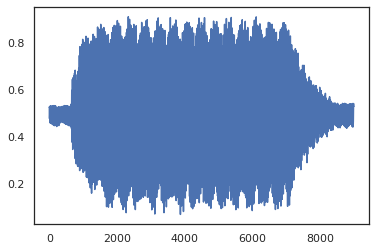

In [14]:
# plot a scaled data
plt.plot(data[0,166]['smcAC'])

## Create Train, Validation, Test Data Sets

We have some functions to creat tensors of the data, return the data in an X-Y format, and remove certain classes from the data sets to get a set of data suitable for anomaly detection

In [14]:
def create_tensor(data_sample, signal_names, start, end, window_size):
    '''Create a tensor from a cut sample. Final tensor will have shape: 
       [# samples, # sample len, # features/sample]
    
    Parameters
    ===========
    data_sample : ndarray
        single data sample containing all the signals
    
    signal_names : tuple
        tuple of all the signals that will be added into the tensor
    '''
    
    s = signal_names[::-1] # only include the six signals, and reverse order
    c = data_sample[s[0]].reshape((9000,1))

    for i in range(len(s)):
        try:
            a = data_sample[s[i+1]].reshape((9000,1)) # reshape to make sure
            c = np.hstack((a,c)) # horizontal stack
        except:
            # reshape into [# samples, # sample len, # features/sample]
            c = c[start:end]
            c = np.reshape(c, (1, c.shape[0],-1))
    
    # split the data
    no_splits = int((end - start) / window_size)
    c = np.vstack(np.split(c, no_splits, axis=1))
            
    return c

def return_xy(df_labels, data, signal_names, start, end, window_size):
    
    temp_cuts = [] # temporary list to hold all the windowed cuts
    temp_labels = []
    X = [] # instantiate X's
    y = [] # instantiate y's

    #iterate throught the df
    for i in df_labels.itertuples():
        cut_data_ind = create_tensor(data[0,i.cut_no], signal_names, start, end, window_size)
        temp_cuts.append(cut_data_ind)
        temp_labels.append(i.tool_class)
        

    for i, tool_class in enumerate(temp_labels):
        for cut_split in temp_cuts[i]:
            y.append(tool_class)
            X.append(cut_split)
            
    # vertical stack the X list (make it into an array)
    X = np.array(X)
    print('Shape of X:', X.shape)
    y = np.array(y)
    print('Shape of y:', y.shape)
    return X, y

def remove_classes(class_to_remove, y_val_slim, X_val_slim):
    """Funciton to remove classes from train/val set"""
    
    # start with y_valid_slim
    index_to_delete = []
    for i, class_digit in enumerate(y_val_slim):
        if class_digit in class_to_remove:
            index_to_delete.append(i)

    y_val_slim = np.delete(y_val_slim, index_to_delete)
    X_val_slim = np.delete(X_val_slim, index_to_delete, axis=0)
    
    return X_val_slim, y_val_slim

In [11]:
# discard certain cuts as they are strange
cuts_remove = [17, 94]
df_labels.drop(cuts_remove, inplace=True)

Next we want to ensure that we have a complete life of the tools in test data (tool_class from 0 to 2). We also need the same for the validation and test set.

- **Test Data:** case 15 (0.5 feed rate), 10 (0.25 feed rate), 5 (0.25 feed rate)
- **Validation Data:** case 11 (0.25 feed rate), 16 (0.5 feed rate)
- Remainder in training data

In [12]:
# split the df_labels into the various train, validation, test sets
val_cases = [11, 13]
test_cases = [5,10,15]
train_cases = []

# there are 16 cases total
for i in range(1,17):
    if i in val_cases or i in test_cases:
        pass
    else:
        train_cases.append(i)

# create the label dataframes for each of the train, val, test sets
df_train = df_labels[df_labels['case'].isin(train_cases)]
df_val = df_labels[df_labels['case'].isin(val_cases)]
df_test = df_labels[df_labels['case'].isin(test_cases)]

Now we create the X-y data sets. We also create a "slimmed-down" version of the training and validation sets. These "slim" data sets have the anomalous data removed (we call the "failure" class -- 2 -- to be anomalous).

In [15]:
signal_names = l[7:]
start = 960
end = 8000
window_size = 64


X_train, y_train = return_xy(df_train, data, signal_names, start, end, window_size)
X_val, y_val = return_xy(df_val, data, signal_names, start, end, window_size)
X_test, y_test = return_xy(df_test, data, signal_names, start, end, window_size)

X_train_slim, y_train_slim = remove_classes([2], y_train, X_train)
print('Shape of X_train_slim:', X_train_slim.shape)
print('Shape of y_train_slim:', y_train_slim.shape)
X_val_slim, y_val_slim = remove_classes([2], y_val, X_val)
print('Shape of X_val_slim:', X_val_slim.shape)
print('Shape of y_val_slim:', y_val_slim.shape)

Shape of X: (11440, 64, 6)
Shape of y: (11440,)
Shape of X: (4180, 64, 6)
Shape of y: (4180,)
Shape of X: (2530, 64, 6)
Shape of y: (2530,)
Shape of X_train_slim: (11110, 64, 6)
Shape of y_train_slim: (11110,)
Shape of X_val_slim: (3520, 64, 6)
Shape of y_val_slim: (3520,)


# 3 - Build Model
We will now be building a convolutional autoencoder.

**What is an autoencoder?**
An autoencoder learns to copy its inputs to its output. It consists of an encoder section, and a decoder section. The data is often "squeezed" through a bottle neck (or a regularization technique is used) to get a lower dimensional representation of the data. This 

![autoencoder_schema](https://upload.wikimedia.org/wikipedia/commons/thumb/3/37/Autoencoder_schema.png/659px-Autoencoder_schema.png)

**How is an autoencoder used in anomaly detection?** <br/>
We will be building an convolutional autoencoder (CAE) to learn what a "normal" cutting signal looks like. We will then use the model to reconstruct cut signals and measure their reconstruction error. Anomolous signals should have a larger reconstruction error.

There are many examples of autoencoders being used for anomaly detection. For example:
- [Detecting anomalies in videos](https://arxiv.org/pdf/1701.01546.pdf)
- [Anomaly Detection using Autoencoders in High Performance Computing Systems](https://arxiv.org/pdf/1811.05269.pdf)

**More Resources:** <br/>
"[Hands-On Machine Learning with Scikit-Learn and TensorFlow](https://www.amazon.ca/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1492032646/ref=sr_1_1?crid=22QX9UK796YMX&keywords=hands+on+machine+learning+with+scikit+learn+and+tensorflow&qid=1573668803&sprefix=hands+on+mac%2Caps%2C161&sr=8-1)" by Aurélien Geron is an excellent, and practical, resource for learning ML, sk-learn, and Tensorflow 2.0.

![title](https://i.imgur.com/02K74an.jpg)

## Setup Model Architecture

Shuffle the data, just to be sure.

In [16]:
from sklearn.utils import shuffle

X_train_slim, y_train_slim = shuffle(X_train_slim, y_train_slim, random_state=0)
X_val_slim, y_val_slim = shuffle(X_val_slim, y_val_slim, random_state=0)
X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_val, y_val = shuffle(X_val, y_val, random_state=0)
X_test, y_test = shuffle(X_test, y_test, random_state=0)

In [25]:
import tensorflow as tf
from tensorflow import keras
import tensorboard

print('TensorFlow version: ', tf.__version__)
print('Keras version: ', keras.__version__)
print('Tensorboard version:', tensorboard.__version__)

TensorFlow version:  2.0.0
Keras version:  2.2.4-tf
Tensorboard version: 2.0.0


In [25]:
# build a CAE
# code modified from Aurélien Geron 
# https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb

tf.random.set_seed(15)
np.random.seed(15)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([64,6], input_shape=[64,6]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(128, kernel_size=5, padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.Conv1D(256, kernel_size=3, padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.Conv1D(512, kernel_size=3, padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool1D(pool_size=2),   
])

conv_decoder = keras.models.Sequential([
    keras.layers.UpSampling1D(size=2, input_shape=[8, 512]),
    keras.layers.Conv1D(256, kernel_size=3, padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.UpSampling1D(size=2),
    keras.layers.Conv1D(128, kernel_size=5, padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.UpSampling1D(size=2),
    keras.layers.Conv1D(6, kernel_size=2, padding='same', activation="selu"),
    keras.layers.Reshape([64, 6])
])

conv_ae = keras.models.Sequential([conv_encoder,conv_decoder])

# MSE and accuracy
conv_ae.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(),metrics=['mean_absolute_error'])

# show the model summaries
conv_encoder.summary()
conv_decoder.summary()

# use tensorboard to track training
log_dir="logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0,
                                                      update_freq='epoch',profile_batch=0)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 64, 6)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 6)             24        
_________________________________________________________________
conv1d (Conv1D)              (None, 64, 128)           3968      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 128)           512       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 32, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 32, 256)           98560     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 256)           1

## Train Model

In [26]:
history = conv_ae.fit(X_train_slim, X_train_slim, epochs=5,
                      validation_data=[X_val_slim, X_val_slim],callbacks=[tensorboard_callback])

Train on 11110 samples, validate on 3520 samples
Epoch 1/5
11110/11110 [==============================] - 8s 752us/sample - loss: 0.0694 - mean_absolute_error: 0.1185 - val_loss: 0.0042 - val_mean_absolute_error: 0.0539
Epoch 2/5
11110/11110 [==============================] - 4s 394us/sample - loss: 0.0032 - mean_absolute_error: 0.0432 - val_loss: 0.0041 - val_mean_absolute_error: 0.0501
Epoch 3/5
11110/11110 [==============================] - 4s 401us/sample - loss: 0.0027 - mean_absolute_error: 0.0397 - val_loss: 0.0024 - val_mean_absolute_error: 0.0370
Epoch 4/5
11110/11110 [==============================] - 4s 396us/sample - loss: 0.0024 - mean_absolute_error: 0.0371 - val_loss: 0.0022 - val_mean_absolute_error: 0.0382
Epoch 5/5
11110/11110 [==============================] - 5s 405us/sample - loss: 0.0024 - mean_absolute_error: 0.0367 - val_loss: 0.0015 - val_mean_absolute_error: 0.0313


## Visualize Results
We now want to visualize some of the results. We will take the encoder portion and look at the latent variables that it generates. To do that, we will use t-SNE (t-Distributed Stochastic Neighbor Embedding) by [van der Maaten](https://lvdmaaten.github.io/tsne/). Of course, sklearn has a good [implementation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). 

In [28]:
# use T-SNE
# code modified from https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb

from sklearn.manifold import TSNE

def encoded_2d_tsne(X_valid_encoded):
    """Returns 2D representation of the latent space via T-SNE"""
        
    np.random.seed(63)
    tsne = TSNE()
    X_valid_2D = tsne.fit_transform(X_valid_encoded[:,:])
    X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())
    return X_valid_2D

def plot_2d_ae(X_valid_2D, y_valid):
    fig, axes = plt.subplots(nrows=1,ncols=1,dpi=150)

    scatter = axes.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], 
                            c=y_valid, s=3, 
                            cmap="Set1", 
                            alpha=0.5, 
                            linewidths=0, 
                            edgecolors=None,label=y_valid)

    # use legend elements to add legend http://bit.ly/2Pe77WK
    legend1 = axes.legend(*scatter.legend_elements(),
                        loc='best',frameon=False)
    
    legend1.get_frame().set_facecolor('none')
    axes.axis('off')
    plt.show()   

In [108]:
# get the 2D embeddings
conv_encoder_latent = conv_encoder(X_val)
conv_encoder_latent_avg = keras.layers.GlobalAveragePooling1D()(conv_encoder_latent).numpy()

X_valid_2D = encoded_2d_tsne(conv_encoder_latent_avg)

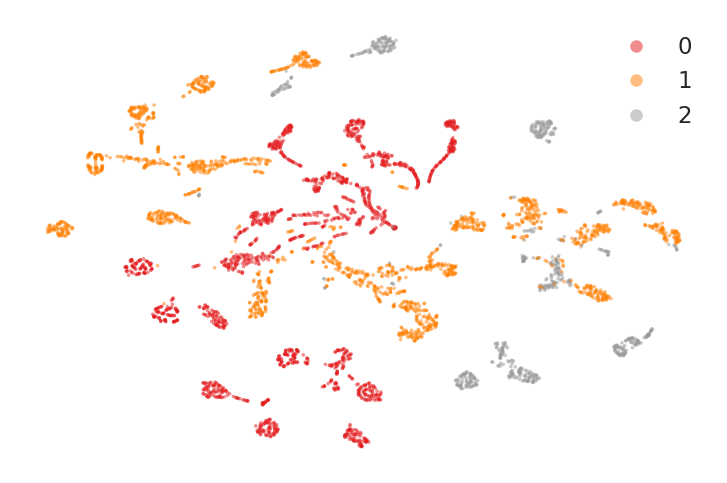

In [109]:
plot_2d_ae(X_valid_2D, y_val)

### Compare the Different Reconstruction Error Methods
Use MSE, RMSE, euclidean distance, and see which one gives the best results. <br/>

Here are the functions to calculate these:

In [ ]:
# build a table with all the RMSE/MSE/Euclidean results from the reconstructions
# sewar is a package that has many image quality assement algos already developed,
# and it can be used as a good guide https://github.com/andrewekhalel/sewar
# However, we will calculate the reconstuction errors across the whole numpy array and then
# put these in a pandas dataframe

def mse(X_val,recon_val):
    """Calculate MSE for images in X_val and recon_val"""
    
    # need to calculate mean across the rows, and then across the columns
    return np.mean(np.mean(np.square(X_val.astype('float32') - recon_val.astype('float32')),axis=1),axis=1)

def rmse(X_val,recon_val):
    """Calculate RMSE for images in X_val and recon_val"""
    return np.sqrt(mse(X_val, recon_val))

def euclidean_distance(X_val,recon_val):
    dist = np.linalg.norm(X_val - recon_val,axis=(1,2))
    return dist

# function that creates a pandas dataframe with the RMSE value, and the associated class
def create_df_reconstruction(rmse_val, y_val, metric, class_to_remove, threshold_val):
    df = pd.DataFrame(data=rmse_val, columns=[metric])
    
    # append the class values
    df['class'] = y_val
    
    # label anomolous (outlier) data as -1, inliers as 1
        # -1 (outlier) is POSITIVE class
        #  1 (inlier) is NEGATIVE class
    new_y_val = []
    for i in y_val:
        if i in class_to_remove:
            new_y_val.append(-1)
        else:
            new_y_val.append(1)
    
    df['true_class'] = new_y_val
    
    # add prediction based on threshold
    df['prediction'] = np.where(df[metric] >= threshold_val,-1,1)
    
    return df

### MSE
We will use MSE as one method to measure reconstruction error.

In [132]:
# get the reconstructions on the X_val_slim dataset, and the X_val dataset
recon_val_slim = conv_ae(X_val_slim).numpy()
recon_val = conv_ae(X_val).numpy()

# calculate MSE reconstruction error
mse_recon_val_slim = mse(X_val_slim, recon_val_slim) # for slim dataset
mse_recon_val = mse(X_val, recon_val) # for complete validation dataset

# class to remove (for df creation)
class_to_remove = np.array([2],dtype='uint8')

We have the reconstruction errors for all the "slim" validation data. Let's see what the maximum value for the reconstruction error is, and what the 90th percental value is. These two values will provide some bounds for when we search for the proper threshold.

In [133]:
# look at the maximum reconstruction error, and the 90th percentile
print(np.max(mse_recon_val_slim))
print(np.percentile(mse_recon_val_slim,90))

0.0055369386
0.00248399677220732


We'll do a very simple parameter search to find the best threshold value. We are trying to find the best ROC_AUC value.

**Metrics?** How does one judge the effectiveness of an anomaly detection technique. ROC_AUC is a common method. Precision and Recall may be good too, depending on the application. Accuracy is usually not a good metric since in anomaly detection is often done on highly unbalanced data.

Best threshold value: 0.0013000000000000002 	ROC score: 55.31%

True Positive: 402
False Positive: 1770
True Negative: 1750
False Negative: 258

Confusion Matix:
[[ 402  258]
 [1770 1750]]


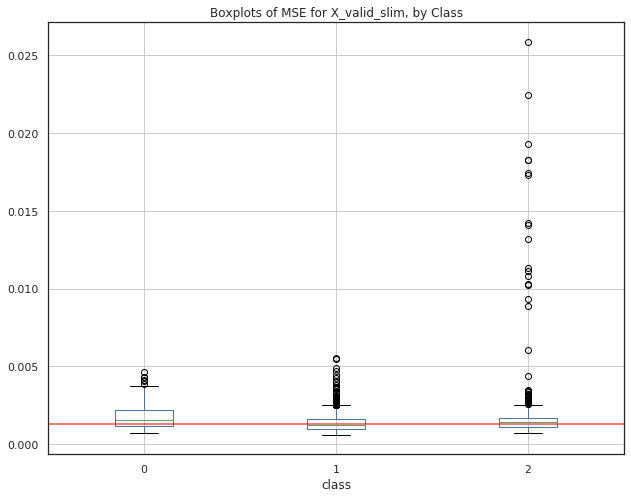

In [140]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

roc_scores = {}
# for i in np.arange(0.1, 150, 0.5):
for i in np.arange(0.0001, 0.2, 0.0001):
     
    threshold_val = i
    df = create_df_reconstruction(mse_recon_val, y_val, "recon_metric",class_to_remove, threshold_val)
    roc_val = roc_auc_score(df['true_class'], df['prediction'])
    roc_scores[i] = roc_val

# return best roc_score and the threshold used to set it
threshold_val = max(zip(roc_scores.values(), roc_scores.keys()))
print('Best threshold value:', threshold_val[1],'\tROC score: {:.2%}'.format(threshold_val[0]))

# use the best threshold value to make a confusion matrix
df = create_df_reconstruction(mse_recon_val, y_val, "recon_metric",class_to_remove, threshold_val[1])


# True Positive
print("\nTrue Positive:",len(df[(df['true_class']==-1) & (df['prediction']==-1)]))
# False Positive -- predict anomaly (-1), when it is actually normal (1)
print("False Positive:",len(df[(df['true_class']==1) & (df['prediction']==-1)]))
# True Negative
print("True Negative:",len(df[(df['true_class']==1) & (df['prediction']==1)]))
#False Negative
print("False Negative:",len(df[(df['true_class']==-1) & (df['prediction']==1)]))

print('\nConfusion Matrix:')
print(confusion_matrix(df['true_class'], df['prediction']))

fig, ax = plt.subplots(figsize=(10,8))
df.boxplot(column=['recon_metric'], by='class', ax=ax).axhline(y=threshold_val[1],c='red',alpha=0.7)
plt.title('Boxplots of MSE for X_valid, by Class')
plt.suptitle('')
plt.show()

![title](https://i.imgur.com/MEfumof.png)

**Note:** Sometimes, it is better to bias the model to detect more false positives than false negative (and vice versa). For example, if you are trying to fraud in a bank, you may want more false positive (thinking it is fraud, when it's not) because the consequences of false negatives may be so high (such as losing millions of dollars in one case of fraud).

As another visualization, we will plot the distribution of the points.

(0, 0.01)

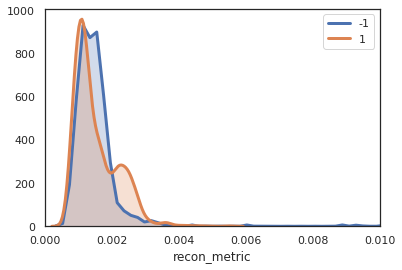

In [138]:
# examples of dist plots https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0
class_list = [-1,1]
for i in class_list:
    subset = df[df['true_class'] == i]
    
    sns.distplot(subset['recon_metric'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},
                 label = i)

plt.xlim(0,0.01)

### RMSE

In [93]:
# calculate RMSE reconstruction error
rmse_recon_val_slim = rmse(X_val_slim, recon_val_slim) # for slim dataset
rmse_recon_val = rmse(X_val, recon_val) # for complete validation dataset

# look at the maximum reconstruction error, and the 90th percentile
print(np.max(rmse_recon_val_slim))
print(np.percentile(rmse_recon_val_slim,90))

0.07186213
0.04321268126368522


Best threshold value: 0.028999999999999984 	ROC score: 73.39%

Confusion Matix:
[[ 585   75]
 [1473 2047]]


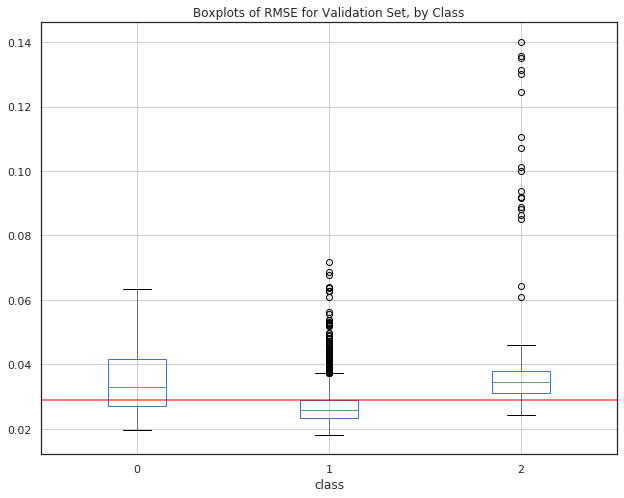

In [96]:
roc_scores = {}
for i in np.arange(0.01, 1.0, 0.001):
     
    threshold_val = i
    df = create_df_reconstruction(rmse_recon_val, y_val, "recon_metric",class_to_remove, threshold_val)
    roc_val = roc_auc_score(df['new_class'], df['prediction'])
    roc_scores[i] = roc_val

# return best roc_score and the threshold used to set it
threshold_val = max(zip(roc_scores.values(), roc_scores.keys()))
print('Best threshold value:', threshold_val[1],'\tROC score: {:.2%}'.format(threshold_val[0]))

# use the best threshold value to make a confusion matrix
df = create_df_reconstruction(rmse_recon_val, y_val, "recon_metric",class_to_remove, threshold_val[1])

print('\nConfusion Matix:')
print(confusion_matrix(df['new_class'], df['prediction']))

fig, ax = plt.subplots(figsize=(10,8))
df.boxplot(column=['recon_metric'], by='class', ax=ax).axhline(y=threshold_val[1],c='red',alpha=0.7)
plt.title('Boxplots of RMSE for Validation Set, by Class')
plt.suptitle('')
plt.show()

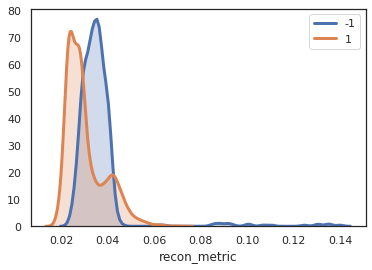

In [95]:
# examples of dist plots https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0
import seaborn as sns

class_list = [-1,1]
for i in class_list:
    subset = df[df['new_class'] == i]
    
    sns.distplot(subset['recon_metric'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},
                 label = i)

# plt.xlim(0,0.01)

### Euclidean Distance

In [346]:
# calculate RMSE reconstruction error
eu_recon_val_slim = euclidean_distance(X_val_slim, recon_val_slim) # for slim dataset
eu_recon_val = euclidean_distance(X_val, recon_val) # for complete validation dataset

# look at the maximum reconstruction error, and the 90th percentile
print(np.max(eu_recon_val_slim))
print(np.percentile(eu_recon_val_slim,90))

1.0064597795544936
0.5964445552641744


Best threshold value: 0.55 	ROC score: 82.52%

Confusion Matix:
[[ 539  121]
 [ 585 2935]]


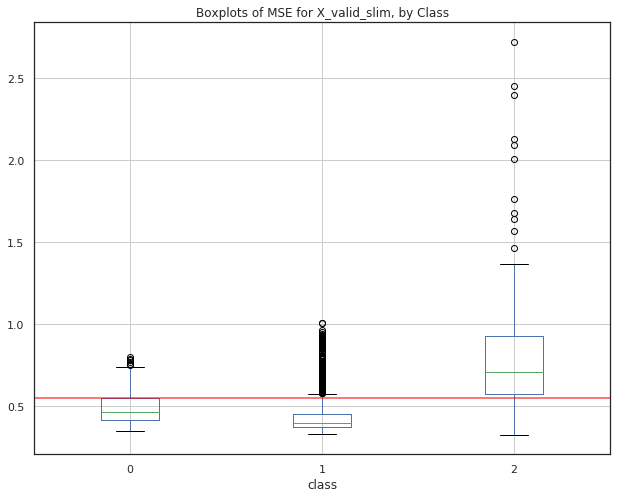

In [347]:
roc_scores = {}
for i in np.arange(0.01, 3, 0.01):
     
    threshold_val = i
    df = create_df_reconstruction(eu_recon_val, y_val, "recon_metric",class_to_remove, threshold_val)
    roc_val = roc_auc_score(df['new_class'], df['prediction'])
    roc_scores[i] = roc_val

# return best roc_score and the threshold used to set it
threshold_val = max(zip(roc_scores.values(), roc_scores.keys()))
print('Best threshold value:', threshold_val[1],'\tROC score: {:.2%}'.format(threshold_val[0]))

# use the best threshold value to make a confusion matrix
df = create_df_reconstruction(eu_recon_val, y_val, "recon_metric",class_to_remove, threshold_val[1])

print('\nConfusion Matix:')
print(confusion_matrix(df['new_class'], df['prediction']))

fig, ax = plt.subplots(figsize=(10,8))
df.boxplot(column=['recon_metric'], by='class', ax=ax).axhline(y=threshold_val[1],c='red',alpha=0.7)
plt.title('Boxplots of MSE for X_valid_slim, by Class')
plt.suptitle('')
plt.show()

## Check Best Model Against Test Data
It appears that the RMSE gives the best result. Now let's check it on the test data.

In [ ]:
# try on test data
threshold_val = threshold_val[1]

# use test data
recon_test = conv_ae(X_test).numpy()

# calculate MSE reconstruction error
rmse_recon_test = rmse(X_test, recon_test) # for complete validation dataset

df = create_df_reconstruction(rmse_recon_test, y_test, "recon_metric",class_to_remove, threshold_val)
roc_val = roc_auc_score(df['new_class'], df['prediction'])

print('Threshold value:', threshold_val,'\tROC score: {:.2%}'.format(roc_val))
print(confusion_matrix(df['new_class'], df['prediction']))